---

<h1 style="text-align: center;font-size: 40px;">Cataract Prediction using INCEPTION V3</h1>

---

<h3>Dataset Information:</h3>
Ocular Disease Intelligent Recognition (ODIR) is a structured ophthalmic database of 5,000 patients with age, color fundus photographs from left and right eyes and doctors' diagnostic keywords from doctors.This dataset is meant to represent ‘‘real-life’’ set of patient information collected by Shanggong Medical Technology Co., Ltd. from different hospitals/medical centers in China. In these institutions, fundus images are captured by various cameras in the market, such as Canon, Zeiss and Kowa, resulting into varied image resolutions.Annotations were labeled by trained human readers with quality control management. They classify patient into eight labels including:

- Normal (N),
- Diabetes (D),
- Glaucoma (G),
- Cataract (C),
- Age related Macular Degeneration (A),
- Hypertension (H),
- Pathological Myopia (M),
- Other diseases/abnormalities (O)

- Here i'm going to make a model which is going to  predict an image is belongs to Normal or Cataract category!

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/Downloads/ml'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
df = pd.read_csv("full_df.csv")
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


> <h3> Extracting Cataract & Normal information from the Dataset </h3>

In [4]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [5]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [6]:
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
left_cataract[:15]

array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
       '465_left.jpg', '477_left.jpg', '553_left.jpg', '560_left.jpg',
       '594_left.jpg', '611_left.jpg', '625_left.jpg'], dtype=object)

In [7]:
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:15]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg'], dtype=object)

In [8]:
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


>Normal Images

In [9]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [10]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [11]:
print(len(cataract),len(normal))

594 500


><h3>Creating Dataset from images</h3>

In [12]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "preprocessed_images/"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset
        

In [13]:
dataset = create_dataset(cataract,1)

100%|██████████| 594/594 [00:08<00:00, 72.24it/s]


In [14]:
len(dataset)

588

In [15]:
dataset = create_dataset(normal,0)

100%|██████████| 500/500 [00:08<00:00, 58.15it/s]


In [16]:
len(dataset)

1088

><h3>Let's see some images</h3>

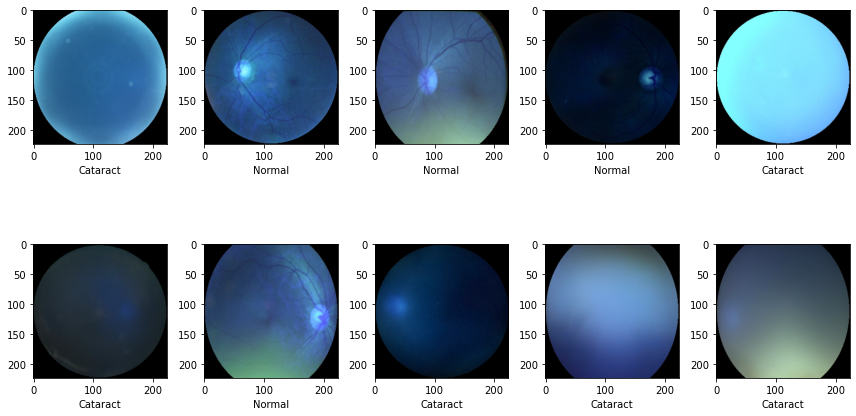

In [17]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

><h3>Dividing dataset into x(features) & y(target)</h3>

In [18]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [19]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

><h3>Creating Model</h3>

In [20]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
InceptionV3 = InceptionV3(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

In [21]:
for layer in InceptionV3.layers:
    layer.trainable = False

In [22]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(InceptionV3)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 1)                 51201     
                                                                 
Total params: 21,853,985
Trainable params: 51,201
Non-trainable params: 21,802,784
_________________________________________________________________


In [24]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [26]:
history = model.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/15
28/28 [==============================] - 93s 3s/step - loss: 24.2032 - accuracy: 0.7161 - val_loss: 10.7641 - val_accuracy: 0.8394
Epoch 2/15
28/28 [==============================] - 95s 3s/step - loss: 6.7451 - accuracy: 0.8368 - val_loss: 4.9338 - val_accuracy: 0.8945
Epoch 3/15
28/28 [==============================] - 108s 4s/step - loss: 2.6544 - accuracy: 0.9057 - val_loss: 4.3032 - val_accuracy: 0.8716
Epoch 4/15
28/28 [==============================] - 109s 4s/step - loss: 2.4824 - accuracy: 0.8805 - val_loss: 3.4613 - val_accuracy: 0.8761
Epoch 5/15
28/28 [==============================] - 104s 4s/step - loss: 1.5406 - accuracy: 0.9172 - val_loss: 9.6119 - val_accuracy: 0.7523
Epoch 6/15
28/28 [==============================] - 94s 3s/step - loss: 1.4831 - accuracy: 0.9149 - val_loss: 2.3253 - val_accuracy: 0.9312
Epoch 7/15
28/28 [==============================] - 99s 4s/step - loss: 1.0373 - accuracy: 0.9402 - val_loss: 16.9169 - val_accuracy: 0.7248
Epoch 8/15
28/

In [28]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

7/7 [==============================] - 9s 1s/step - loss: 1.3300 - accuracy: 0.9633
loss: 1.3300156593322754
Accuracy: 0.963302731513977


---

<h1 style="text-align: center;font-size: 20px;">Thanks for Reading!!</h1>

---